In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

Have a whole lot runs, all with many summaries saved. Can we go through and pull out the data using tensorflow directly or will we have to download the data manually?

In [2]:
import tensorflow as tf

In [3]:
def get_scalar_events(filename, tag):
    """Gets a list of numbers out of an events file by going through all summaries and looking
    for a specific tag"""
    results = []
    for event in tf.train.summary_iterator(filename):
        for val in event.summary.value:
            if val.tag == tag:
                results.append(val.simple_value)
    return results

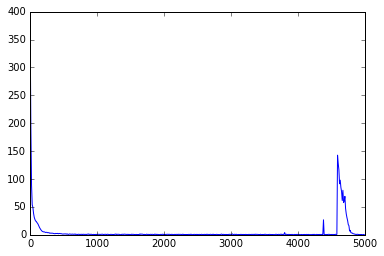

In [14]:
events_file = '../sequential_classifiers/cont_grid/100x1/cp-gate-combined/0/events.out.tfevents.1473775538.midnight-espresso.ecs.vuw.ac.nz'
losses = get_scalar_events(events_file, 'loss')
xs = np.arange(len(losses)) * 10  # summarised every ten
ys = np.array(losses)

plt.plot(xs, ys)

It works, now we need to come up with a clever way of extracting all the info for a given task.

In [15]:
def get_task(task, root='../sequential_classifiers/cont_grid/'):
    """Gets a bunch of nested dicts with all the data for all cells for a given task.
    `task` should be a string of the form `axb` where `a` is sequence length (100, 200 or 500)
    and `b` is the number of items (1, 2 or 3)"""
    task_dir = os.path.join(root, task)
    cells = os.listdir(task_dir)
    all_data = {}
    for cell in cells:
        all_data[cell] = {'losses': [], 'gnorms': []}
        for run in range(5):
            # here we assume there is only one file in the run directories
            run_dir = os.path.join(task_dir, cell, '{}'.format(run))
            events_file = os.path.join(run_dir, os.listdir(run_dir)[0])
            run_losses = get_scalar_events(events_file, 'loss')
            run_gnorms = get_scalar_events(events_file, 'gnorm')
            all_data[cell]['losses'].append(run_losses)
            all_data[cell]['gnorms'].append(run_gnorms)
        all_data[cell]['losses'] = np.array(all_data[cell]['losses'])
        all_data[cell]['gnorms'] = np.array(all_data[cell]['gnorms'])
    return all_data

In [16]:
def plot_mean_stdd(data, tag, title, xlabel='mini-batch', ylabel='loss', step=1):
    """Plots all the cells, mean and stddevs of runs"""
    colors = {'cp-gate-combined': 'blue',
              'gru': 'green',
              'lstm': 'red'}
    cell_names = {'cp-gate-combined': 'CPG-C',
                  'gru': 'GRU',
                  'lstm': 'LSTM'}
    for cell in data:
        means = data[cell][tag].mean(axis=0)
        stddevs = data[cell][tag].std(axis=0)
        plt.plot(xs[::step], means[::step], label=cell_names[cell], color=colors[cell])
        plt.fill_between(xs[::step], (means-stddevs)[::step], (means+stddevs)[::step], color=colors[cell], alpha=0.3)
    plt.ylim((0, 30))
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

def plot_all_runs(data, tag, title, xlabel='mini-batch', ylabel='loss', step=1, cells=None):
    """Plots all the cells, mean and stddevs of runs"""
    if not cells:
        cells = [cell for cell in data]
    colors = {'cp-gate-combined': 'blue',
              'gru': 'green',
              'lstm': 'red'}
    cell_names = {'cp-gate-combined': 'CPG-C',
                  'gru': 'GRU',
                  'lstm': 'LSTM'}
    for cell in data:
        if cell in cells:
            for i in range(5):
                run = data[cell][tag][i, ...]
                label = cell_names[cell] if i == 0 else None
                plt.plot(xs[::step], run[::step], label=label, color=colors[cell], alpha=0.5)
    plt.ylim((0, 30))
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    
def plot_median(data, tag, title, xlabel='mini-batch', ylabel='loss', step=1, cells=None, minmax=True):
    """Plots all the cells, mean and stddevs of runs"""
    if not cells:
        cells = [cell for cell in data]
    colors = {'cp-gate-combined': 'blue',
              'gru': 'green',
              'lstm': 'red'}
    cell_names = {'cp-gate-combined': 'CPG-C',
                  'gru': 'GRU',
                  'lstm': 'LSTM'}
    for cell in data:
        if cell in cells:
            label = cell_names[cell]
            plt.plot(xs[::step], np.median(data[cell][tag][:, ::step], axis=0), label=label, color=colors[cell])
            if minmax:
                plt.fill_between(xs[::step], np.min(data[cell][tag][:, ::step], axis=0), 
                                 np.max(data[cell][tag][:, ::step], axis=0), color=colors[cell], alpha=0.5)
            
    plt.ylim((0, 30))
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

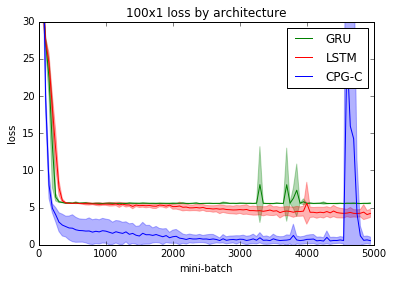

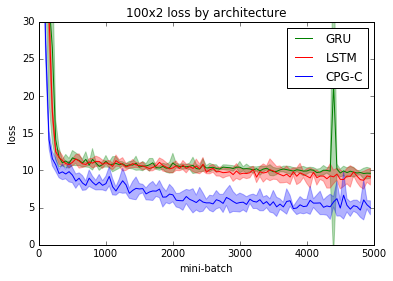

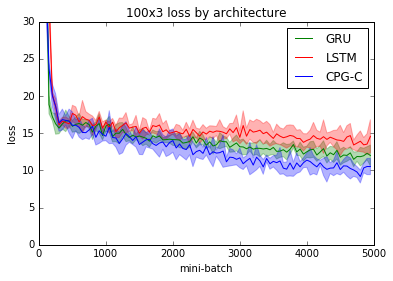

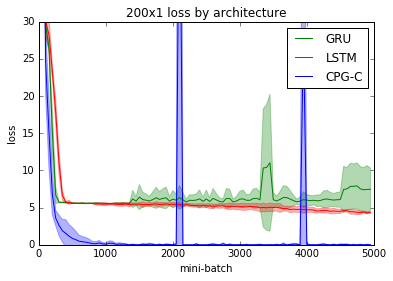

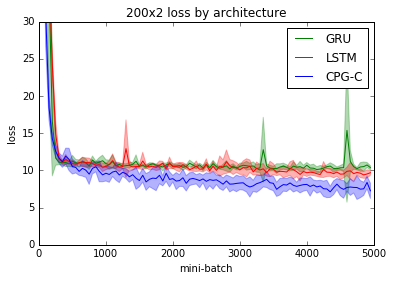

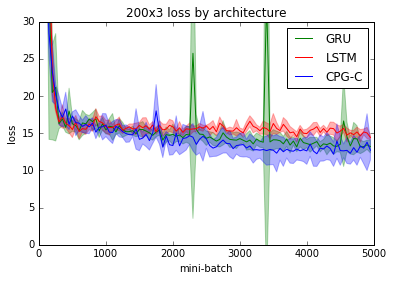

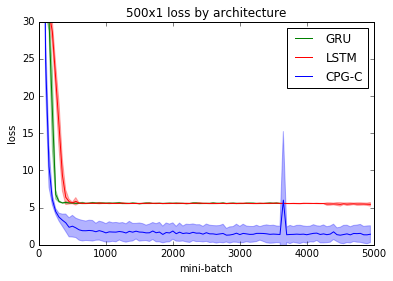

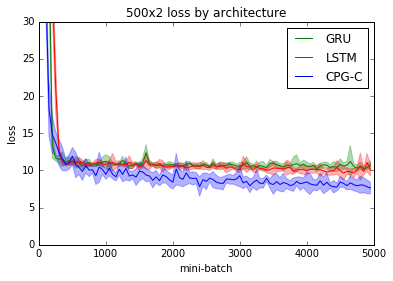

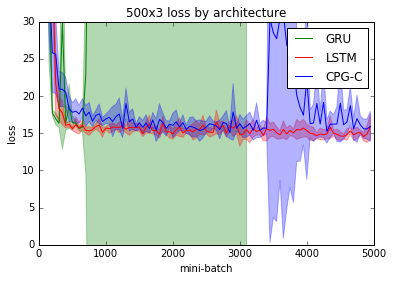

In [17]:
from itertools import product
for seq_len, num_items in product(['100', '200', '500'], ['1', '2', '3']):
    task = '{}x{}'.format(seq_len, num_items)
    data = get_task(task)
    plot_mean_stdd(data, 'losses', '{} loss by architecture'.format(task), step=5)

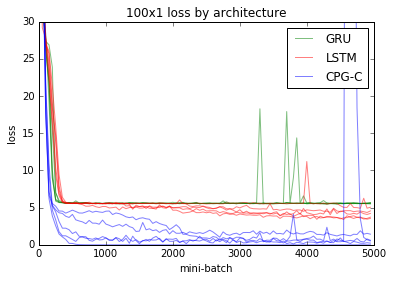

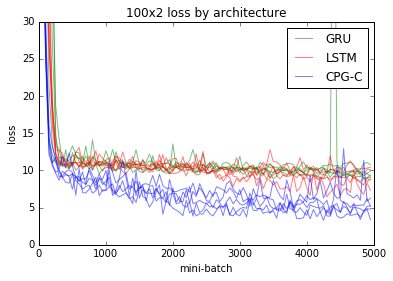

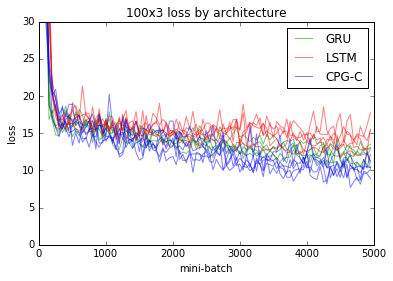

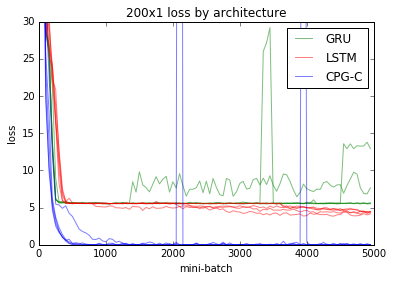

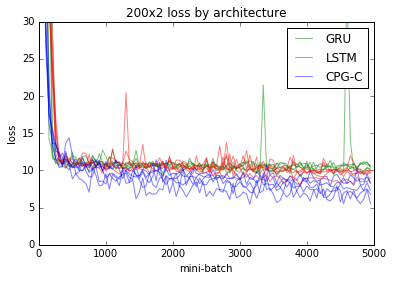

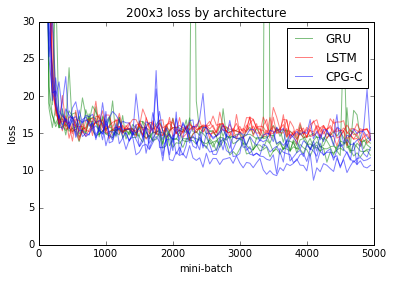

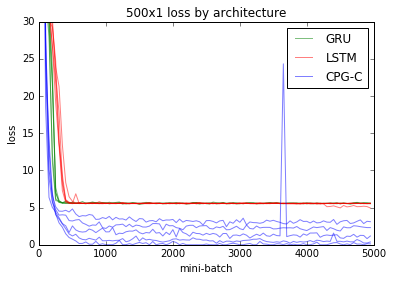

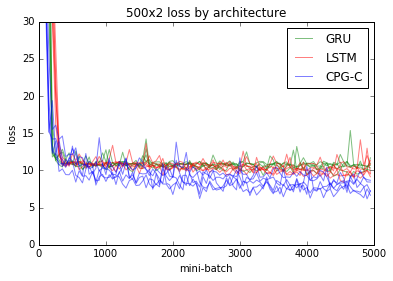

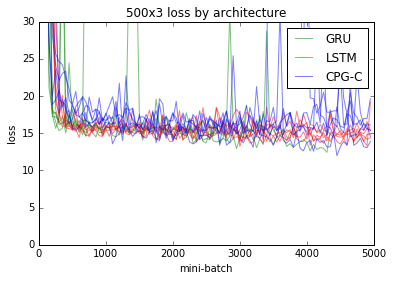

In [18]:
for seq_len, num_items in product(['100', '200', '500'], ['1', '2', '3']):
    task = '{}x{}'.format(seq_len, num_items)
    data = get_task(task)
    plot_all_runs(data, 'losses', '{} loss by architecture'.format(task), step=5)

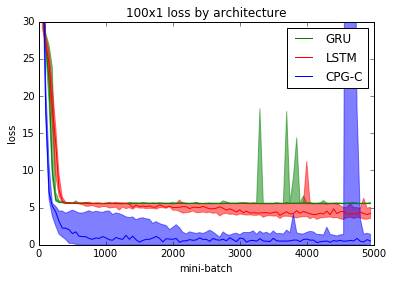

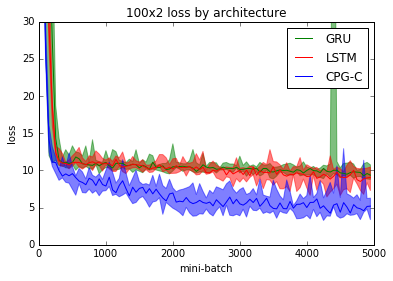

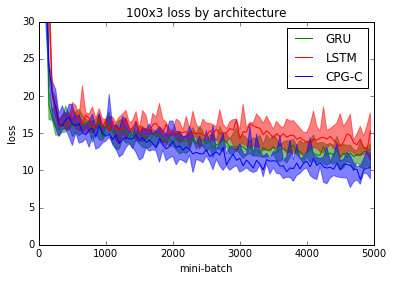

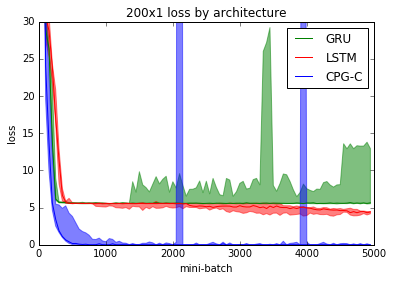

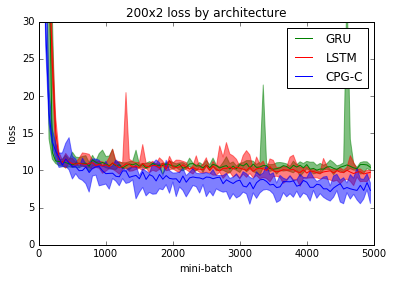

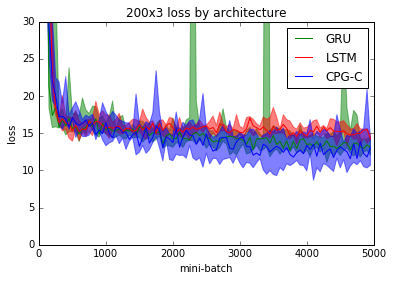

/home/mathewpaul1/.pyenv/versions/3.5.1/envs/py3-workspace/lib/python3.5/site-packages/numpy/lib/function_base.py:3578: RuntimeWarning: Invalid value encountered in median for 27 results
  RuntimeWarning)


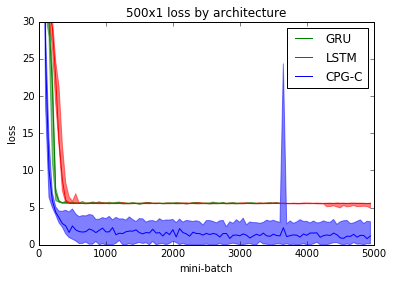

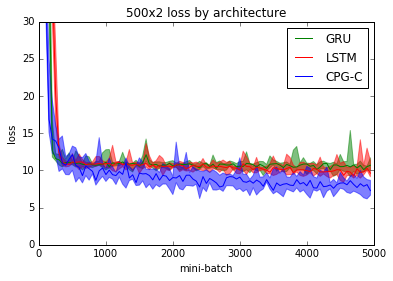

/home/mathewpaul1/.pyenv/versions/3.5.1/envs/py3-workspace/lib/python3.5/site-packages/numpy/lib/function_base.py:3578: RuntimeWarning: Invalid value encountered in median for 37 results
  RuntimeWarning)


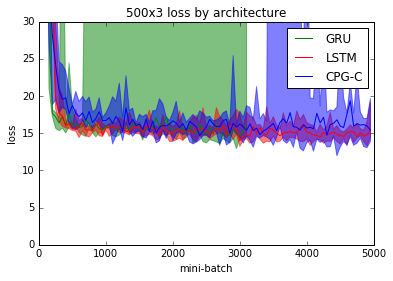

In [19]:
for seq_len, num_items in product(['100', '200', '500'], ['1', '2', '3']):
    task = '{}x{}'.format(seq_len, num_items)
    data = get_task(task)
    plot_median(data, 'losses', '{} loss by architecture'.format(task), step=5, minmax=True)